<table style="border: none" align="left">
   <tr style="border: none">
              <th style="border: none"><font face="verdana" size="5" color="black"><b>IBM Cloud Discovery Lab: Neural Network Model</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=false" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
</table>

### Lab Details:

This lab was created to demonstrate Watson Studio's capabilities to integrate with open source frameworks and libraries such as Tensorflow and Keras, providing a high level of customization within the Notebooks whether you prefer to program using Python, R or Scala, and using a broad set of tools into IBM Cloud's environment architecture.

#### Services and Tools:

In addition to Watson Studio, We'll make use of the following IBM Cloud's services:

- Apache Spark;
- Cloud Object Storage;
- Python Web App with Flask;
- Watson Machine Learning;


#### Datasets used:
AIRCRAFT
http://image-net.org/synset?wnid=n02686568

BIRDS
http://image-net.org/synset?wnid=n01503061

HUMANS
http://image-net.org/synset?wnid=n02472987



## Libraries Installation

In [1]:
!pip install wget

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20181008123851-0000
  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/spark/shared/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
!pip install dict

    100% |################################| 573kB 1.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for dict ... done
  Stored in directory: /home/spark/shared/.cache/pip/wheels/2f/d7/ba/896495dbaaea79e41838a8613dc6f6ca47e3284e74862de550
  Running setup.py bdist_wheel for public ... done
  Stored in directory: /home/spark/shared/.cache/pip/wheels/2c/d4/3a/121976cc622274b35fea10c7b6c3f7fcff6d459513d1a35955
  Running setup.py bdist_wheel for self ... done
  Stored in directory: /home/spark/shared/.cache/pip/wheels/93/96/9e/cd15af0258b716dc605b51cd754d2eee08477ea266ef8e5b70
Successfully built dict public self
Target directory /home/spark/shared/user-libs/python3/__pycache__ already exists. Specify --upgrade to force replacement.


In [3]:
!pip install dictionary

    100% |################################| 450kB 1.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for dictionary ... done
  Stored in directory: /home/spark/shared/.cache/pip/wheels/1a/d9/68/454d25edea0076732cf9f0522b415395f3bf6c6839db56b3cb
Successfully built dictionary
Target directory /home/spark/shared/user-libs/python3/__pycache__ already exists. Specify --upgrade to force replacement.


In [5]:
!pip install watson-machine-learning-client

    100% |################################| 942kB 644kB/s ta 0:00:01
    100% |################################| 8.7MB 100kB/s ta 0:00:011
    100% |################################| 92kB 1.3MB/s ta 0:00:01
    100% |################################| 51kB 1.4MB/s ta 0:00:011
    100% |################################| 153kB 1.6MB/s ta 0:00:01
    100% |################################| 51kB 1.9MB/s ta 0:00:011
    100% |################################| 51kB 1.4MB/s ta 0:00:011
    100% |################################| 143kB 1.5MB/s ta 0:00:01
    100% |################################| 215kB 1.2MB/s ta 0:00:01
    100% |################################| 13.8MB 66kB/s eta 0:00:01
    100% |################################| 512kB 671kB/s ta 0:00:01
    100% |################################| 143kB 1.6MB/s ta 0:00:01
    100% |################################| 61kB 1.6MB/s ta 0:00:011
    100% |################################| 788kB 716kB/s ta 0:00:01
    100% |#######################

In [6]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

## Libraries Import

In [7]:
import os, urllib3, requests, json, time, requests, wget, base64, glob
import shutil, random, tarfile, ibm_boto3, dict, dictionary
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf

from IPython.display import clear_output, Image, display, HTML
from skimage import img_as_float
from six.moves import urllib
from uuid import uuid4
from urllib.request import urlopen
from botocore.client import Config
from watson_machine_learning_client import WatsonMachineLearningAPIClient
from keras.preprocessing import image
from keras.applications.inception_v3 import decode_predictions, preprocess_input

%matplotlib inline

Conveniently, Tensorflow includes a [script](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/image_retraining/retrain.py) that will handle the transfer learning of either [Inception V3 model](https://github.com/tensorflow/models/tree/master/research/slim#pre-trained-models) or a [MobileNet](https://research.googleblog.com/2017/06/mobilenets-open-source-models-for.html). Both were trained on [ImageNet 2012 competition](http://www.image-net.org/challenges/LSVRC/2012/) images (1000 categories and 1.2 million images).

**Inception V3**: higher accuracy but slower — Top 1 Accuracy on ImageNet: 78% — ~85MB model size <br />
**MobileNets**: smaller and faster, but lower accuracy. — Top 1 Accuracy on ImageNet: 70.7% — ~19MB model size

## Import Inception V3 Retrain architecture

In [8]:
!wget -O retrain.py https://raw.githubusercontent.com/tensorflow/tensorflow/7f53659bc67bba5567ea3f0b69710329843e0228/tensorflow/examples/image_retraining/retrain.py

--2018-10-08 12:40:36--  https://raw.githubusercontent.com/tensorflow/tensorflow/7f53659bc67bba5567ea3f0b69710329843e0228/tensorflow/examples/image_retraining/retrain.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60540 (59K) [text/plain]
Saving to: 'retrain.py'

retrain.py          100%[===================>]  59.12K  --.-KB/s    in 0.01s   

2018-10-08 12:40:36 (6.01 MB/s) - 'retrain.py' saved [60540/60540]



## Import architecture labels

In [9]:
!wget -O label_image.py https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/label_image/label_image.py

--2018-10-08 12:40:40--  https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/label_image/label_image.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4707 (4.6K) [text/plain]
Saving to: 'label_image.py'

label_image.py      100%[===================>]   4.60K  --.-KB/s    in 0s      

2018-10-08 12:40:40 (70.1 MB/s) - 'label_image.py' saved [4707/4707]



## Importing Training and Testing ImageNet datasets from the dropbox

In [14]:
!wget -O training.zip https://www.dropbox.com/s/3fg7gwd0dqfcy3d/training.zip?dl=0

--2018-10-08 12:41:29--  https://www.dropbox.com/s/3fg7gwd0dqfcy3d/training.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3fg7gwd0dqfcy3d/training.zip [following]
--2018-10-08 12:41:30--  https://www.dropbox.com/s/raw/3fg7gwd0dqfcy3d/training.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd3671532810d12113ce4d746f8.dl.dropboxusercontent.com/cd/0/inline/ASiFQQxKX47kr_KoGqwnUid8c2mjj_ffY4KZVa4CfqegsE5YFJyGOuHHU2FmItanvdn1Bw0Ibwo3Yxt8p-ybZBH4OGGQ0-nDkqYR11PABL5aVpb-nGUUXIQ_N3rn9jg9N9najzebrFV4QP9KBBtGh2RkJXXlyjTNr3tnTPza5NAbNtlN1AVue9ZorsnPUZUHt1o/file [following]
--2018-10-08 12:41:30--  https://ucd3671532810d12113ce4d746f8.dl.dropboxusercontent.com/cd/0/inline/ASiFQQxKX47kr_KoGqwnUid8c2mjj_ffY4KZVa4Cfqe

In [15]:
!wget -O testing.zip https://www.dropbox.com/s/jd7tmchpidyzi2c/testing.zip?dl=0

--2018-10-08 12:41:37--  https://www.dropbox.com/s/jd7tmchpidyzi2c/testing.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jd7tmchpidyzi2c/testing.zip [following]
--2018-10-08 12:41:38--  https://www.dropbox.com/s/raw/jd7tmchpidyzi2c/testing.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8453a84eedac48a6e38b87f9ab.dl.dropboxusercontent.com/cd/0/inline/ASh120VAOOvvWBydAaL4oo8JO8dPDecw1pL6TbK5YDN8J6AY26uobwcZdq_rbOELaOox3lyGPV71hs3BZEJsw-GzZ623xmWb6GEudvj3x6bQXU1eoujg2IXFKznGsoFj63XlNA6jl5LzRWtIgPJipRjKLhT1Hv2G2iDbJ0ps7sQCFy4nxZRKOQKSQ1kC027T4Cs/file [following]
--2018-10-08 12:41:38--  https://uc8453a84eedac48a6e38b87f9ab.dl.dropboxusercontent.com/cd/0/inline/ASh120VAOOvvWBydAaL4oo8JO8dPDecw1pL6TbK5YDN8J6

In [16]:
!unzip -o ./training.zip

Archive:  ./training.zip
   creating: training/
  inflating: training/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/training/
  inflating: __MACOSX/training/._.DS_Store  
   creating: training/Aircraft/
  inflating: training/Aircraft/n02686568_1076.JPEG  
   creating: __MACOSX/training/Aircraft/
  inflating: __MACOSX/training/Aircraft/._n02686568_1076.JPEG  
  inflating: training/Aircraft/n02686568_831.JPEG  
  inflating: __MACOSX/training/Aircraft/._n02686568_831.JPEG  
  inflating: training/Aircraft/n02686568_1125.JPEG  
  inflating: __MACOSX/training/Aircraft/._n02686568_1125.JPEG  
  inflating: training/Aircraft/n02686568_954.JPEG  
  inflating: __MACOSX/training/Aircraft/._n02686568_954.JPEG  
  inflating: training/Aircraft/n02686568_112.JPEG  
  inflating: __MACOSX/training/Aircraft/._n02686568_112.JPEG  
  inflating: training/Aircraft/n02686568_1294.JPEG  
  inflating: __MACOSX/training/Aircraft/._n02686568_1294.JPEG  
  inflating: training/Aircraft/n02686568_1056

In [17]:
!unzip -o ./testing.zip

Archive:  ./testing.zip
   creating: testing/
   creating: testing/Aircrafts/
  inflating: testing/Aircrafts/n04583620_54.JPEG  
   creating: __MACOSX/testing/
   creating: __MACOSX/testing/Aircrafts/
  inflating: __MACOSX/testing/Aircrafts/._n04583620_54.JPEG  
  inflating: testing/Aircrafts/n04583620_59.JPEG  
  inflating: __MACOSX/testing/Aircrafts/._n04583620_59.JPEG  
  inflating: testing/Aircrafts/n04583620_55.JPEG  
  inflating: __MACOSX/testing/Aircrafts/._n04583620_55.JPEG  
  inflating: testing/Aircrafts/n04583620_14.JPEG  
  inflating: __MACOSX/testing/Aircrafts/._n04583620_14.JPEG  
  inflating: testing/Aircrafts/n04583620_64.JPEG  
  inflating: __MACOSX/testing/Aircrafts/._n04583620_64.JPEG  
  inflating: testing/Aircrafts/n04583620_69.JPEG  
  inflating: __MACOSX/testing/Aircrafts/._n04583620_69.JPEG  
  inflating: testing/Aircrafts/n04583620_70.JPEG  
  inflating: __MACOSX/testing/Aircrafts/._n04583620_70.JPEG  
  inflating: testing/Aircrafts/n04583620_8.JPEG  
  inflati

## Directory Lookup

In [18]:
!ls  -aLF ./training/


./  ../  .DS_Store  Aircraft/  Birds/  Humans/


In [19]:
!ls  -aLF ./testing/

./  ../  .DS_Store  Aircrafts/	Birds/	Humans/


In [20]:
os.remove('training/.DS_Store') 
os.remove('training/Aircraft/.DS_Store') 
os.remove('training/Birds/.DS_Store') 
os.remove('training/Humans/.DS_Store') 

os.remove('testing/.DS_Store') 

FileNotFoundError: [Errno 2] No such file or directory: 'testing/Aircraft/.DS_Store'

## Visualizing the training images

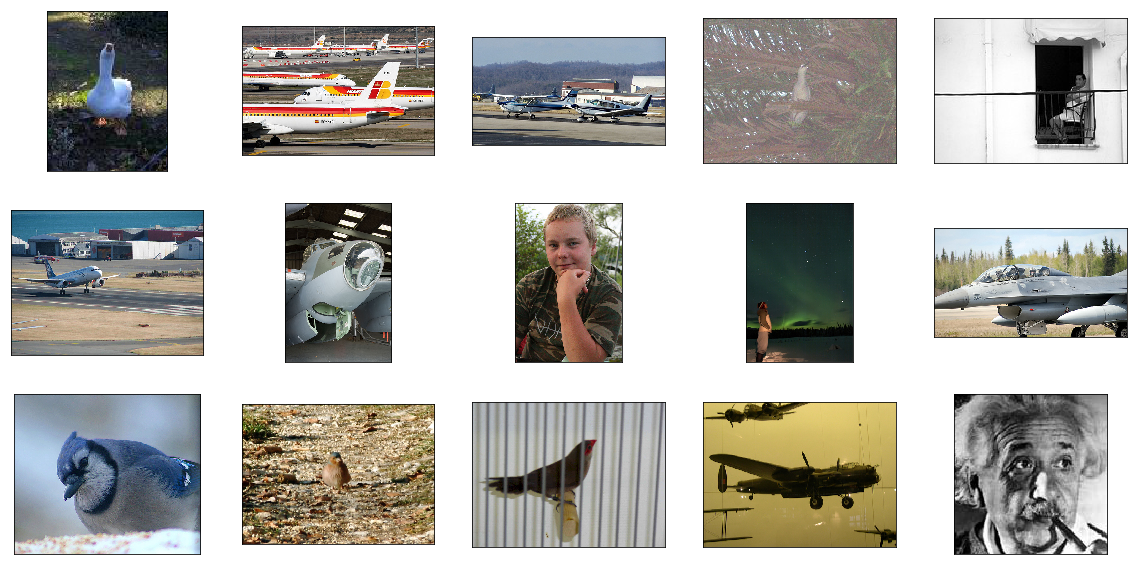

In [21]:
directories = os.listdir('training/')
images = []
for folder in os.listdir('training'):
    path = os.path.join('training', folder)
    images.extend([os.path.join(path, f) for f in os.listdir(path)])

# Plot some sample images in the dataset.
plt.figure(figsize=(20,10))
for i in range(15):
    img = mpimg.imread(random.choice(images))
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

## Training process to Applying transfer learning using the Inception V3 Architecture

Normally training a model from scratch would take an enormous amount of time and resources. Here, however, we will only be training the final layer of the network, so the training time is much more reasonable.

Let's go over some of the arguments we will be using.

The ***bottleneck_dir*** will be used to cache the outputs of the lower layers on disk so they don’t have to repeatedly be recalculated. 'Bottleneck' is an informal term often used for the layer just before the final output layer that actually does the classification. Since images are reused several times during training, it would be too time-consuming to calculate the layers before the bottleneck for each image each time we use it. These lower layers never changed, so we can just run the image through them once, then cache and reuse the outputs.


The ***how_many_training_steps*** option is used to specify that we want to run this example for 1000 iterations. This amount can be experimented with.

The ***model_dir*** option asks us where to store the trained model.

The ***summaries_dir*** option asks us where to save summary logs for TensorBoard (which we won't be using here).

The ***output_graph*** option is where the script will write out a version of the Inception v3 neural network with a final layer retrained to our categories. 

The ***output_labels*** will be the file where the labels are stored. These labels are the same as the image folder names.

Lastly, we use the ***image_dir*** argument to pass in the directory containing the labeled class folders containing our images.

In [22]:
!python retrain.py \
    --bottleneck_dir=./ml-model/bottlenecks \
    --how_many_training_steps 300 \
    --learning_rate 0.01 \
    --train_batch_size 200 \
    --model_dir=./ml-model/pretrained_model \
    --summaries_dir=./retrain-logs \
    --output_graph=./ml-model/retrained_graph.pb \
    --output_labels=./ml-model/retrained_labels.txt \
    --image_dir=./training/ \
    --saved_model_dir =./saved-model/

INFO:tensorflow:Looking for images in 'Aircraft'
INFO:tensorflow:Looking for images in 'Humans'
INFO:tensorflow:Looking for images in 'Birds'
>> Downloading inception-2015-12-05.tgz 100.0%
INFO:tensorflow:Successfully downloaded inception-2015-12-05.tgz 88931400 bytes.
Extracting file from  ./ml-model/pretrained_model/inception-2015-12-05.tgz
Model path:  ./ml-model/pretrained_model/classify_image_graph_def.pb
2018-10-08 12:42:46.754531: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-10-08 12:42:46.754583: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-10-08 12:42:46.754594: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instruct

### Training Concepts

As the retraining script runs, you'll see a series of step outputs, each showing the following information:

* The **training accuracy** shows the percentage of the images used in the current training batch that were correctly labeled
* **Validation accuracy**: The validation accuracy is the precision (percentage of correctly-labelled images) on a randomly-selected group of images from a different set.
* **Cross entropy** is a loss function that shows how well the learning process is progressing (the lower the better).

If the *training accuracy* is high but the *validation accuracy* stays low, the model is overfitting or memorizing specific features in the training images that don't help it classify images more generally.

When training keep an eye on the *cross entropy*. The goal is to get this value as small as possible, and you can tell if the model is learning by if the loss is trending downwards or not.


## Visualizing the Tensorflow model

In [23]:
# This visualization code taken from: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [24]:
with tf.gfile.FastGFile("./ml-model/retrained_graph.pb", 'rb') as f:
    graph_def = tf.GraphDef()

    # Parse the graph.
    graph_def.ParseFromString(f.read())
    show_graph(graph_def)

## Visualizing the testing images

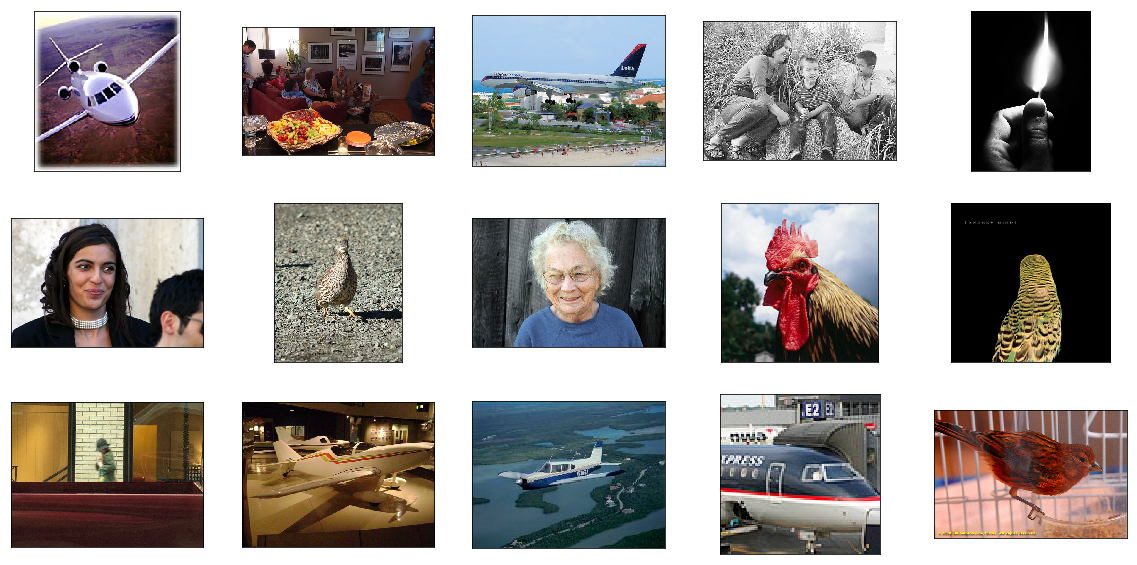

In [25]:
directories_testing = os.listdir('testing/')
images_testing = []
for folder in os.listdir('testing'):
    path_testing = os.path.join('testing', folder)
    images.extend([os.path.join(path_testing, f) for f in os.listdir(path_testing)])

# Plot some sample images in the dataset.
plt.figure(figsize=(20,10))
for i in range(15):
    img = mpimg.imread(random.choice(images))
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

## Validating the model and providing an image path for a test 

In [26]:
model_dir = './ml-model'

test_image = './testing/Aircrafts/n04583620_4.JPEG'

input_layer = 'Mul'
input_height = 299
input_width = 299


%env MODEL_DIR=$model_dir
%env INPUT_HEIGHT=$input_height
%env INPUT_WIDTH=$input_width
%env TEST_IMAGE=$test_image
%env INPUT_LAYER=$input_layer

env: MODEL_DIR=./ml-model
env: INPUT_HEIGHT=299
env: INPUT_WIDTH=299
env: TEST_IMAGE=./testing/Aircrafts/n04583620_4.JPEG
env: INPUT_LAYER=Mul


## Running the scripts and getting the results of the Image Recognition tests

2018-10-08 12:49:29.623819: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-10-08 12:49:29.623874: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-10-08 12:49:29.623885: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2018-10-08 12:49:29.623905: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2018-10-08 12:49:29.623923: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

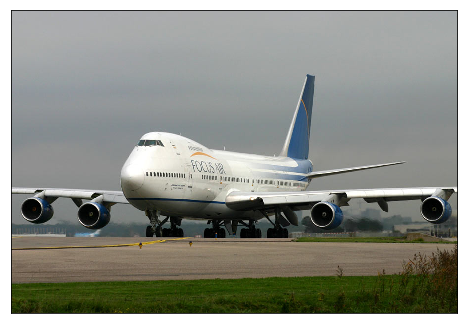

In [27]:
img = mpimg.imread(test_image)
plt.figure(figsize=(8,8))
plt.imshow(img)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

!python ./label_image.py \
    --graph=$MODEL_DIR/retrained_graph.pb --labels=$MODEL_DIR/retrained_labels.txt \
    --input_layer=$INPUT_LAYER \
    --output_layer=final_result \
    --input_height=$INPUT_HEIGHT --input_width=$INPUT_WIDTH \
    --image=$TEST_IMAGE










## Creating REST API 

In [28]:
cos_credentials = {
  "Insert your credentials here"
}

auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

In [29]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                         ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

In [30]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))


Creating bucket "training-data-17e60a72-090b-4e45-bc10-aa6d3cc698f3"...
Creating bucket "training-results-17e60a72-090b-4e45-bc10-aa6d3cc698f3"...


In [31]:
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

In [32]:
from urllib.request import urlopen

bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.
Uploading data train-labels-idx1-ubyte.gz...
train-labels-idx1-ubyte.gz is uploaded.
Uploading data t10k-images-idx3-ubyte.gz...
t10k-images-idx3-ubyte.gz is uploaded.
Uploading data t10k-labels-idx1-ubyte.gz...
t10k-labels-idx1-ubyte.gz is uploaded.


In [33]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

training-data-17e60a72-090b-4e45-bc10-aa6d3cc698f3
  File: t10k-images-idx3-ubyte.gz, 1610.23kB
  File: t10k-labels-idx1-ubyte.gz, 4.44kB
  File: train-images-idx3-ubyte.gz, 9680.10kB
  File: train-labels-idx1-ubyte.gz, 28.20kB
training-results-17e60a72-090b-4e45-bc10-aa6d3cc698f3


## Integration with Watson Machine Learning client API services

In [34]:
wml_credentials = {
  "Insert your credentials here"
}

In [35]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [36]:
client.version

'1.0.333'

In [38]:
model_dir_path = '=./saved-model'

## Properties to integrate the model with the Watson Machine Learning (WML) API

In [40]:
model_meta_props = {client.repository.ModelMetaNames.NAME: "ibm_disco_lab",
                            client.repository.ModelMetaNames.AUTHOR_NAME: "Jorge Chagas",
                            client.repository.ModelMetaNames.AUTHOR_EMAIL: "jorge.barbosa@ibm.com",
                            client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
                            client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.5",
                            client.repository.ModelMetaNames.RUNTIME_NAME: "python",
                            client.repository.ModelMetaNames.RUNTIME_VERSION: "3.5"}
published_model_details = client.repository.store_model(model=model_dir_path, meta_props=model_meta_props, training_data='./training/')

In [41]:
definition_uid = client.repository.get_model_uid(published_model_details) 

In [42]:
definition_uid

'6e80275b-3b88-43f2-8ffa-59cf9975688b'

In [43]:
model_details = client.repository.get_details(definition_uid)

## Model details into the WML

In [44]:
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "evaluation_metrics_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/2b7fea01-fded-476a-a559-fe5e10d6a416/published_models/6e80275b-3b88-43f2-8ffa-59cf9975688b/evaluation_metrics",
    "tags": [],
    "deployments": {
      "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/2b7fea01-fded-476a-a559-fe5e10d6a416/published_models/6e80275b-3b88-43f2-8ffa-59cf9975688b/deployments",
      "count": 0
    },
    "learning_configuration_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/2b7fea01-fded-476a-a559-fe5e10d6a416/published_models/6e80275b-3b88-43f2-8ffa-59cf9975688b/learning_configuration",
    "latest_version": {
      "url": "https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/6e80275b-3b88-43f2-8ffa-59cf9975688b/versions/baf19772-38aa-4e9f-bb17-0ae18730ca65",
      "guid": "baf19772-38aa-4e9f-bb17-0ae18730ca65",
      "created_at": "2018-10-08T16:53:18.273Z"
    },
    "runtime_environment": "python-3.5",
    "model_type": "tensorflow-1

In [45]:
client.repository.list_models()

------------------------------------  -------------  ------------------------  --------------
GUID                                  NAME           CREATED                   FRAMEWORK
6e80275b-3b88-43f2-8ffa-59cf9975688b  ibm_disco_lab  2018-10-08T16:53:18.167Z  tensorflow-1.5
0da0b4d5-0142-4f67-9466-767148ed7b64  ibm_disco_lab  2018-10-08T16:52:44.671Z  tensorflow-1.5
------------------------------------  -------------  ------------------------  --------------


In [46]:
loaded_model = client.repository.load(definition_uid)

In [47]:
loaded_model

In [48]:
print("Url: " + client.repository.get_model_url(model_details))

Url: https://us-south.ml.cloud.ibm.com/v3/wml_instances/2b7fea01-fded-476a-a559-fe5e10d6a416/published_models/6e80275b-3b88-43f2-8ffa-59cf9975688b


In [49]:
model_uid = client.repository.get_model_uid(model_details)
print("Saved model uid: " + model_uid)

Saved model uid: 6e80275b-3b88-43f2-8ffa-59cf9975688b


## Verification for the model deployment

In [50]:
deployment_details = client.deployments.create(model_uid, "IBM Disco")



#######################################################################################

Synchronous deployment creation for uid: '6e80275b-3b88-43f2-8ffa-59cf9975688b' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS.
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='2fe79927-682a-4de8-ae48-71c5ea0a9cf1'
------------------------------------------------------------------------------------------------




In [51]:
scoring_url =  client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/2b7fea01-fded-476a-a559-fe5e10d6a416/deployments/2fe79927-682a-4de8-ae48-71c5ea0a9cf1/online


In [54]:
url = 'https://us-south.ml.cloud.ibm.com'
username = "your WML username"
password = "your WLM password"
scoring_endpoint = scoring_url

In [55]:
headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(username, password))
path = '{}/v3/identity/token'.format(url)
response = requests.get(path, headers=headers)
mltoken = json.loads(response.text).get('token')
print(mltoken)

None


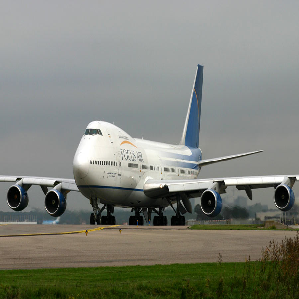

In [56]:
img = image.load_img('./testing/Aircrafts/n04583620_4.JPEG',target_size=(299,299))
img

In [57]:
input_image = image.img_to_array(img)
input_image = np.expand_dims(input_image, axis=0)
input_image = preprocess_input(input_image).tolist()

In [58]:
scoring_data = {'values': input_image}

In [59]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'values': [[0.9793381690979004, 0.007157232612371445, 0.01350459735840559]]}


In [60]:
predictions.get('values')

[[0.9793381690979004, 0.007157232612371445, 0.01350459735840559]]